In [246]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import wrangle
import scipy.stats


### Acquire Data

In [299]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


In [300]:
query = '''SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, propertylandusedesc, taxvaluedollarcnt, yearbuilt, fips, transactiondate 
           FROM zillow.propertylandusetype 
           RIGHT JOIN zillow.properties_2017 
             ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
           JOIN zillow.predictions_2017 
             ON properties_2017.parcelid = predictions_2017.parcelid
           WHERE propertylandusedesc IN ("Single Family Residential", "Inferred Single Family Residential");
         ''' 
df = pd.read_sql(query, get_connection('zillow'))

df.head()
    

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,propertylandusedesc,taxvaluedollarcnt,yearbuilt,taxamount,fips,transactiondate
0,4.0,3.5,3100.0,Single Family Residential,1023282.0,1998.0,11013.72,6059.0,2017-01-01
1,2.0,1.0,1465.0,Single Family Residential,464000.0,1967.0,5672.48,6111.0,2017-01-01
2,3.0,2.0,1243.0,Single Family Residential,564778.0,1962.0,6488.30,6059.0,2017-01-01
3,4.0,3.0,2376.0,Single Family Residential,145143.0,1970.0,1777.51,6037.0,2017-01-01
4,4.0,3.0,2962.0,Single Family Residential,773303.0,1950.0,9516.26,6037.0,2017-01-01


In [301]:
df.shape

(52442, 9)

In [302]:
#sort values by transaction date to see if there are a small number if dates outside of 2017, there is only one 
df = df.sort_values(by='transactiondate', ascending=False)

In [303]:
#drop the first row, the only 2018 column
df.drop(index=df.index[0], axis=0, inplace=True)

In [304]:
#Because propertylandusedesc was only imported for the purpose of filtering, it will be dropped 
df = df.drop(columns=['propertylandusedesc', 'transactiondate'])

In [305]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
52440,3.0,2.0,1762.0,522000.0,1955.0,6317.15,6037.0
52439,3.0,1.0,1032.0,49546.0,1954.0,876.43,6037.0
52438,4.0,2.0,1612.0,67205.0,1964.0,1107.48,6111.0
52437,2.0,2.0,1286.0,354621.0,1940.0,4478.43,6037.0
52311,4.0,4.0,2440.0,1550000.0,1937.0,18655.00,6037.0


In [306]:
df.shape

(52441, 7)

In [307]:
#number of null values 
df.isnull().sum()

bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet     82
taxvaluedollarcnt                 1
yearbuilt                       116
taxamount                         4
fips                              0
dtype: int64

In [308]:
df = df.dropna()
df.shape

(52315, 7)

In [309]:
#retained 99.7% data
52315/52441

0.9975972998226579

In [310]:
df.columns

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'yearbuilt', 'taxamount', 'fips'],
      dtype='object')

In [311]:
df.shape

(52315, 7)

### Bedroom Outliers 

In [260]:
df.bedroomcnt.quantile(0.25)

3.0

In [261]:
df.bedroomcnt.quantile(0.75)

4.0

In [262]:
IQR = 1

In [263]:
#Anything below 1.5 bedrooms is an outlier 
3 - (1.5* 1)

1.5

In [264]:
#Anything above 5.5 bedrooms is an outlier 
4 + (1.5*1)

5.5

In [265]:
upper_outliers = df.bedroomcnt > 5.5
df[upper_outliers]

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
52315,6.0,2.0,2475.0,306636.0,1912.0,3874.20,6037.0
52200,6.0,4.0,3686.0,429334.0,1958.0,5267.71,6037.0
51963,6.0,4.0,2810.0,405754.0,1974.0,4817.40,6059.0
51904,7.0,4.0,4600.0,824050.0,1957.0,10126.41,6037.0
52040,6.0,4.5,4534.0,531025.0,1965.0,6400.60,6059.0
...,...,...,...,...,...,...,...
144,6.0,4.0,3733.0,799634.0,1999.0,10794.22,6059.0
170,6.0,6.0,3659.0,2010195.0,1950.0,22708.18,6037.0
226,6.0,5.0,6249.0,3681324.0,1924.0,44772.63,6037.0
174,6.0,3.0,1875.0,136310.0,1958.0,1847.28,6059.0


In [266]:
upper_outliers.sum()

778

In [267]:
lower_outliers = df.bedroomcnt < 1.5
df[lower_outliers]

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
52432,1.0,1.0,624.0,81706.0,1944.0,1131.24,6037.0
52388,0.0,1.0,1020.0,104000.0,1930.0,2708.57,6037.0
52163,0.0,0.0,2307.0,499000.0,1948.0,6315.67,6037.0
52175,0.0,1.0,440.0,1374602.0,1947.0,16591.34,6037.0
52255,1.0,1.0,800.0,913725.0,1932.0,11084.69,6037.0
...,...,...,...,...,...,...,...
287,1.0,1.0,784.0,188067.0,1952.0,2357.43,6037.0
466,1.0,1.0,520.0,32640.0,1922.0,509.53,6037.0
88,1.0,1.0,455.0,86152.0,1922.0,1305.58,6059.0
227,1.0,1.0,528.0,342000.0,1929.0,4144.87,6037.0


In [268]:
lower_outliers.sum()

662

In [312]:
#Drop Outliers 
df.drop(df[df['bedroomcnt'] > 5.5].index, inplace = True)

In [313]:
#Drop Outliers 
df.drop(df[df['bedroomcnt'] < 1.5].index, inplace = True)

In [314]:
df.shape

(51480, 7)

### Bathroom Outliers

In [272]:
df.bathroomcnt.quantile(0.25)

2.0

In [273]:
df.bathroomcnt.quantile(0.75)

3.0

In [274]:
IQR = 1 

In [275]:
#Anything below a half bath is an outlier 
2 - (1.5 * 1)

0.5

In [276]:
#Anything above 4.5 bathrooms is an outlier 
3 + (1.5 * 1)

4.5

In [316]:
#drop outliers
df.drop(df[df['bathroomcnt'] > 5.5].index, inplace = True)

In [317]:
df.shape

(51116, 7)

### Square Feet Outliers 

In [280]:
df.calculatedfinishedsquarefeet.quantile(0.25)

1260.0

In [281]:
df.calculatedfinishedsquarefeet.quantile(0.75)

2250.0

In [282]:
#IQR 
2305 - 1268

1037

In [283]:
#There is no such thing as negative square feet, so the lower bound will not be dropped 
1268 - (1.5 * 1037)

-287.5

In [284]:
#Every property over 3860.5 square feet is an outlier 
2305 + (1.5 * 1037)

3860.5

In [320]:
df.drop(df[df['calculatedfinishedsquarefeet'] > 3860].index, inplace = True)

In [321]:
df.shape

(49503, 7)

### Tax Value Outliers 

In [287]:
df.taxvaluedollarcnt.quantile(0.25)

185003.5

In [288]:
df.taxvaluedollarcnt.quantile(0.75)

574294.0

In [289]:
#IQR 
618617 - 193701

424916

In [188]:
#No negative value homes
1268 - (1.5 * 424916)

-636106.0

In [336]:
#Homes above 639,670 are outliers 
2305 + (1.5 * 424916)

639679.0

In [322]:
df.drop(df[df['taxvaluedollarcnt'] > 639679].index, inplace = True)

In [323]:
df.shape

(44273, 7)

In [333]:
#remove column tax amount 
#using would be cheating because we would not know the tax amount until we knew the tax assessed home value 
df.drop(columns=['taxamount'])

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips
52440,3,2.0,1762,522000,1955,6037
52439,3,1.0,1032,49546,1954,6037
52438,4,2.0,1612,67205,1964,6111
52437,2,2.0,1286,354621,1940,6037
52320,3,1.0,1468,523019,1949,6037
...,...,...,...,...,...,...
1,2,1.0,1465,464000,1967,6111
5,2,1.0,738,218552,1922,6037
4,4,3.0,2962,773303,1950,6037
3,4,3.0,2376,145143,1970,6037


In [334]:
df.dtypes

bedroomcnt                        int64
bathroomcnt                     float64
calculatedfinishedsquarefeet      int64
taxvaluedollarcnt                 int64
yearbuilt                         int64
taxamount                       float64
fips                              int64
dtype: object

In [335]:
df.fips.value_counts()

6037    29118
6059    11399
6111     3756
Name: fips, dtype: int64

### Visuals

<AxesSubplot:xlabel='bedroomcnt'>

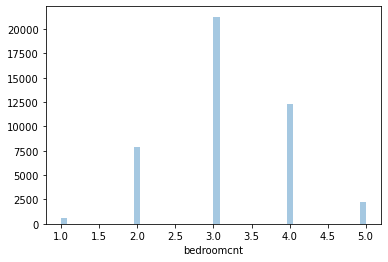

In [324]:
sns.distplot(df['bedroomcnt'], kde=False)

Takeaway: 
- Bedroom Count appears normally distributed

<AxesSubplot:xlabel='bathroomcnt'>

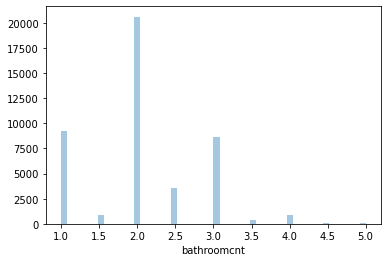

In [325]:
sns.distplot(df['bathroomcnt'], kde=False)

Takeaway: 
- Bathroom Count appears normally distributed

<AxesSubplot:xlabel='calculatedfinishedsquarefeet'>

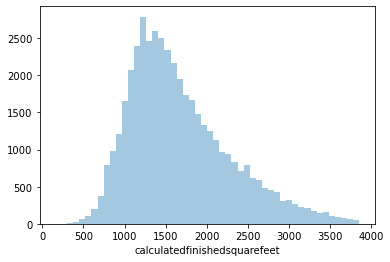

In [326]:
sns.distplot(df['calculatedfinishedsquarefeet'], kde=False)

Takeaway: 
- Calculated Square Feet appears normally distributed

<AxesSubplot:xlabel='taxvaluedollarcnt'>

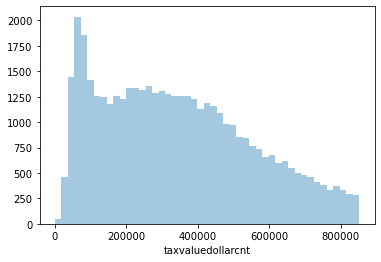

In [327]:
sns.distplot(df['taxvaluedollarcnt'], kde=False)

Takeaway: 
- Most of the homes appear to have a value of 150000
- As the property tax value increases, the number of homes decreases

<AxesSubplot:xlabel='yearbuilt'>

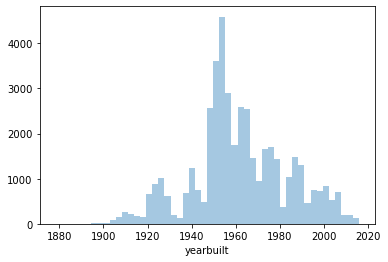

In [328]:
sns.distplot(df['yearbuilt'], kde=False)

Takeaway: 
- Year built appears to be normally distributed 
- Home builds peaked between 1940 and 1960

In [330]:
# fips, yearbuilt, and bedrooms can be integers
df["fips"] = df["fips"].astype(int)
df["yearbuilt"] = df["yearbuilt"].astype(int)
df["bedroomcnt"] = df["bedroomcnt"].astype(int)
df["taxvaluedollarcnt"] = df["taxvaluedollarcnt"].astype(int)
df["calculatedfinishedsquarefeet"] = df["calculatedfinishedsquarefeet"].astype(int)

In [337]:
df.fips.value_counts()

6037    29118
6059    11399
6111     3756
Name: fips, dtype: int64